https://github.com/dmnfarrell/teaching/blob/master/SIR_modelling/covid19_mesa.ipynb

In [1]:
import time, enum
import numpy as np
import pandas as pd
import pylab as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

In [2]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    RECOVERED = 2

## Agent

In [3]:
class MyAgent(Agent):
    """ An agent in an epidemic model."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = self.random.normalvariate(20,40)        
        self.state = State.SUSCEPTIBLE  
        self.infection_time = 0

    def move(self):
        """Move the agent"""

        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def status(self):
        """Check infection status"""
        
        if self.state == State.INFECTED:     
            drate = self.model.death_rate
            alive = np.random.choice([0,1], p=[drate,1-drate])
            if alive == 0:
                self.model.schedule.remove(self)            
            t = self.model.schedule.time-self.infection_time
            if t >= self.recovery_time:          
                self.state = State.RECOVERED
            #print (self.model.schedule.time,self.recovery_time,t)

    def contact(self):
        """Find close contacts and infect"""
        
        cellmates = self.model.grid.get_cell_list_contents([self.pos])       
        if len(cellmates) > 1:
            #other = self.random.choice(cellmates)
            for other in cellmates:
                #print (self.model.schedule.time,self.state,other.state)                
                if self.random.random() > model.ptrans:
                    continue
                if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:                    
                    other.state = State.INFECTED
                    other.infection_time = self.model.schedule.time
                    other.recovery_time = model.get_recovery_time()
                
    def step(self):
        self.status()
        self.move()
        self.contact()

## Model

In [4]:
class InfectionModel(Model):
    """A model for infection spread."""
    
    def __init__(self, N=10, width=10, height=10, ptrans=0.5, 
                 progression_period=3, progression_sd=2, death_rate=0.0193, recovery_days=21,
                 recovery_sd=7):
        
        self.num_agents = N
        self.initial_outbreak_size = 1
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd
        self.ptrans = ptrans
        self.death_rate = death_rate
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True
        self.dead_agents = []
        # Create agents
        for i in range(self.num_agents):
            a = MyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            #make some agents infected at start
            infected = np.random.choice([0,1], p=[0.98,0.02])
            if infected == 1:
                a.state = State.INFECTED
                a.recovery_time = self.get_recovery_time()
            
        self.datacollector = DataCollector(
            #model_reporters={"Gini": compute_gini}, 
            agent_reporters={"State": "state"})

    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [5]:
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Infected','Recovered']
    X.columns = labels[:len(X.columns)]
    return X
    
def plot_states(model,ax):    
    steps = model.schedule.steps
    X = get_column_data(model)
    X.plot(ax=ax,lw=3,alpha=0.8)

In [6]:
pop=300
steps=100
st=time.time()
model = InfectionModel(pop, 20, 20, ptrans=0.5)
for i in range(steps):
    model.step()
print (time.time()-st)
agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model))

2.1227779388427734
      Susceptible  Infected  Recovered
Step                                  
0             294         6          0
1             292         8          0
2             290        10          0
3             281        18          0
4             272        27          0
...           ...       ...        ...
95              3         0        188
96              3         0        188
97              3         0        188
98              3         0        188
99              3         0        188

[100 rows x 3 columns]


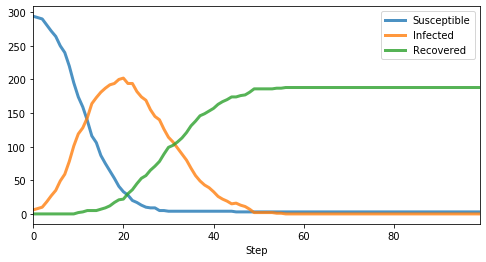

In [7]:
f,ax=plt.subplots(1,1,figsize=(8,4))
plot_states(model,ax)
plt.savefig('SIR.png',dpi=150)

## Parameter Variation

In [8]:
def compute_max_infections(model):
    X=get_column_data(model)
    try:
        return X.Infected.max()
    except:
        return 0

compute_max_infections(model)

202

In [9]:
from mesa.batchrunner import BatchRunner
fixed_params = {
    "width": 20,
    "height": 20,
    "N": 300,
}
#variable_params = {"N": range(20, 200, 10)}
variable_params = {"ptrans": np.arange(.05, .9, .1)}
batch_run = BatchRunner(
    InfectionModel,
    variable_params,
    fixed_params,
    iterations=3,
    max_steps=100,
    model_reporters={"Inf": compute_max_infections}
)

batch_run.run_all()

27it [01:06,  2.48s/it]


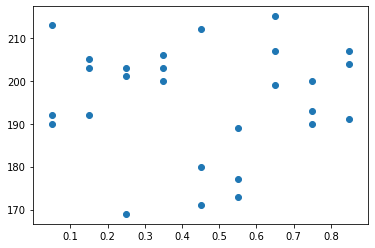

In [10]:
run_data = batch_run.get_model_vars_dataframe()
#run_data#.head()
plt.scatter(run_data.ptrans, run_data.Inf)

In [11]:
from InfectionModel import *
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer


def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "Color": "red",
                 "r": 0.5}
    return portrayal

grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)
server = ModularServer(InfectionModel,
                       [grid],
                       "Infection Model",
                       {"N":100, "width":10, "height":10})
server.port = 8521 # The default
server.launch()

ModuleNotFoundError: No module named 'InfectionModel'

ModuleNotFoundError: No module named 'MoneyModel'